# Overview

1. Project Instructions & Prerequisites
2. Learning Objectives
3. Data Preparation
4. Create Categorical Features with TF Feature Columns
5. Create Continuous/Numerical Features with TF Feature Columns
6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers
7. Evaluating Potential Model Biases with Aequitas Toolkit


#  1. Project Instructions & Prerequisites

## Project Instructions

**Context**: EHR data is becoming a key source of real-world evidence (RWE) for the pharmaceutical industry and regulators to [make decisions on clinical trials](https://www.fda.gov/news-events/speeches-fda-officials/breaking-down-barriers-between-clinical-trials-and-clinical-care-incorporating-real-world-evidence). You are a data scientist for an exciting unicorn healthcare startup that has created a groundbreaking diabetes drug that is ready for clinical trial testing. It is a very unique and sensitive drug that requires administering the drug over at least 5-7 days of time in the hospital with frequent monitoring/testing and patient medication adherence training with a mobile application. You have been provided a patient dataset from a client partner and are tasked with building a predictive model that can identify which type of patients the company should focus their efforts testing this drug on. Target patients are people that are likely to be in the hospital for this duration of time and will not incur significant additional costs for administering this drug to the patient and monitoring.  

In order to achieve your goal you must build a regression model that can predict the estimated hospitalization time for a patient and use this to select/filter patients for your study.


**Expected Hospitalization Time Regression Model:** Utilizing a synthetic dataset(denormalized at the line level augmentation) built off of the UCI Diabetes readmission dataset, students will build a regression model that predicts the expected days of hospitalization time and then convert this to a binary prediction of whether to include or exclude that patient from the clinical trial.

This project will demonstrate the importance of building the right data representation at the encounter level, with appropriate filtering and preprocessing/feature engineering of key medical code sets. This project will also require students to analyze and interpret their model for biases across key demographic groups. 

Please see the project rubric online for more details on the areas your project will be evaluated.

### Dataset

Due to healthcare PHI regulations (HIPAA, HITECH), there are limited number of publicly available datasets and some datasets require training and approval. So, for the purpose of this exercise, we are using a dataset from UC Irvine(https://archive.ics.uci.edu/ml/datasets/Diabetes+130-US+hospitals+for+years+1999-2008) that has been modified for this course. Please note that it is limited in its representation of some key features such as diagnosis codes which are usually an unordered list in 835s/837s (the HL7 standard interchange formats used for claims and remits).

**Data Schema**
The dataset reference information can be https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/
. There are two CSVs that provide more details on the fields and some of the mapped values.

## Project Submission 

When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "student_project_submission.ipynb" and save another copy as an HTML file by clicking "File" -> "Download as.."->"html". Include the "utils.py" and "student_utils.py" files in your submission. The student_utils.py should be where you put most of your code that you write and the summary and text explanations should be written inline in the notebook. Once you download these files, compress them into one zip file for submission.

## Prerequisites 

- Intermediate level knowledge of Python
- Basic knowledge of probability and statistics
- Basic knowledge of machine learning concepts
- Installation of Tensorflow 2.0 and other dependencies(conda environment.yml or virtualenv requirements.txt file provided)

## Environment Setup

For step by step instructions on creating your environment, please go to https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/README.md.

# 2.  Learning Objectives

By the end of the project, you will be able to 
   - Use the Tensorflow Dataset API to scalably extract, transform, and load datasets and build datasets aggregated at the line, encounter, and patient data levels(longitudinal)
   - Analyze EHR datasets to check for common issues (data leakage, statistical properties, missing values, high cardinality) by performing exploratory data analysis.
   - Create categorical features from Key Industry Code Sets (ICD, CPT, NDC) and reduce dimensionality for high cardinality features by using embeddings 
   - Create derived features(bucketing, cross-features, embeddings) utilizing Tensorflow feature columns on both continuous and categorical input features
   - SWBAT use the Tensorflow Probability library to train a model that provides uncertainty range predictions that allow for risk adjustment/prioritization and triaging of predictions
   - Analyze and determine biases for a model for key demographic groups by evaluating performance metrics across groups by using the Aequitas framework 


# 3. Data Preparation

In [1]:
# from __future__ import absolute_import, division, print_function, unicode_literals
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import pandas as pd
import aequitas as ae
# Put all of the helper functions in utils
from utils import build_vocab_files, show_group_stats_viz, aggregate_dataset, preprocess_df, df_to_dataset, posterior_mean_field, prior_trainable
pd.set_option('display.max_columns', 500)
# this allows you to make changes and save in student_utils.py and the file is reloaded every time you run a code block
%load_ext autoreload
%autoreload
import seaborn as sns
import random

In [2]:
!pip install -U seaborn


Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 285 kB 5.8 MB/s eta 0:00:01


In [3]:
#OPEN ISSUE ON MAC OSX for TF model training
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

## Dataset Loading and Schema Review

Load the dataset and view a sample of the dataset along with reviewing the schema reference files to gain a deeper understanding of the dataset. The dataset is located at the following path https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/starter_code/data/final_project_dataset.csv. Also, review the information found in the data schema https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/

In [4]:
dataset_path = "./data/final_project_dataset.csv"
df = pd.read_csv(dataset_path)

## Determine Level of Dataset (Line or Encounter)

**Question 1**: Based off of analysis of the data, what level is this dataset? Is it at the line or encounter level? Are there any key fields besides the encounter_id and patient_nbr fields that we should use to aggregate on? Knowing this information will help inform us what level of aggregation is necessary for future steps and is a step that is often overlooked. 

In [5]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,?,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,?,?,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,?,?,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,?,?,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,?,?,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


(array([1.39122e+05, 1.81700e+03, 1.13300e+03, 6.70000e+01, 8.90000e+02,
        1.18000e+02, 2.00000e+02, 1.80000e+01, 5.50000e+01, 4.00000e+00]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

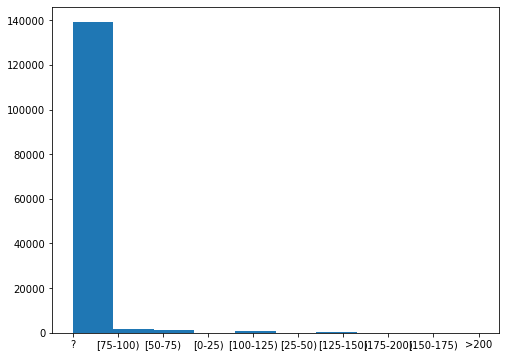

In [6]:
plt.figure(figsize=(8,6))
plt.hist(df['weight']) # right-skewed Normal Distribution.

In [7]:
df = df.replace('?', np.nan)

In [8]:
df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO


In [9]:
total_rows = len(df)

In [10]:
unique_encounters = df['encounter_id'].nunique()

In [11]:
if total_rows > unique_encounters:
    print("Data is at line level")
elif total_rows == unique_encounters:
    print("Data could be at encounter level")

Data is at line level


Data is at line level

encounter_id and patient_nbr are only fields that we should use to aggregate on

In [12]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'primary_diagnosis_code', 'other_diagnosis_codes', 'number_outpatient',
       'number_inpatient', 'number_emergency', 'num_lab_procedures',
       'number_diagnoses', 'num_medications', 'num_procedures', 'ndc_code',
       'max_glu_serum', 'A1Cresult', 'change', 'readmitted'],
      dtype='object')

In [13]:
#encounter_id and patient_nbr are the only fields we should use to aggregate on. 

## Analyze Dataset

**Question 2**: Utilizing the library of your choice (recommend Pandas and Seaborn or matplotlib though), perform exploratory data analysis on the dataset. In particular be sure to address the following questions:  
    - a. Field(s) with high amount of missing/zero values
    - b. Based off the frequency histogram for each numerical field, which numerical field(s) has/have a Gaussian(normal) distribution shape?
    - c. Which field(s) have high cardinality and why (HINT: ndc_code is one feature)
    - d. Please describe the demographic distributions in the dataset for the age and gender fields.
    


**OPTIONAL**: Use the Tensorflow Data Validation and Analysis library to complete. 
- The Tensorflow Data Validation and Analysis library(https://www.tensorflow.org/tfx/data_validation/get_started) is a useful tool for analyzing and summarizing dataset statistics. It is especially useful because it can scale to large datasets that do not fit into memory. 
- Note that there are some bugs that are still being resolved with Chrome v80 and we have moved away from using this for the project. 

**Student Response**: ??

In [14]:
######NOTE: The visualization will only display in Chrome browser. ########
#full_data_stats = tfdv.generate_statistics_from_csv(data_location='./data/final_project_dataset.csv') 
#tfdv.visualize_statistics(full_data_stats)

In [15]:
numerical_fields = ['age', 'weight', 'time_in_hospital', 'number_outpatient', 'number_inpatient', 
                    'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications',
                    'num_procedures']

categotical_fields = ['race', 'gender', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                     'payer_code', 'medical_specialty', 'primary_diagnosis_code', 'other_diagnosis_codes',
                     'ndc_code', 'max_glu_serum', 'A1Cresult', 'change']

(array([  161.,   733.,  1927.,  4964., 13729., 25095., 32741., 36928.,
        23527.,  3619.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

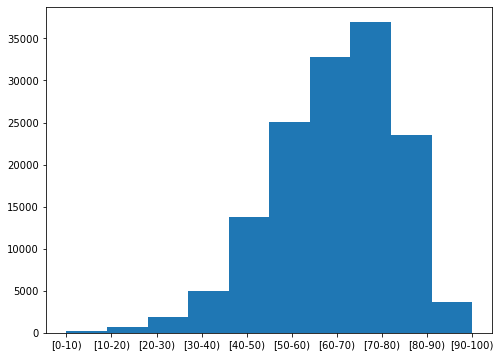

In [16]:
plt.figure(figsize=(8,6))
plt.hist(df['age']) # left-skewed Normal Distribution.

In [17]:
df['weight']

0         NaN
1         NaN
2         NaN
3         NaN
4         NaN
         ... 
143419    NaN
143420    NaN
143421    NaN
143422    NaN
143423    NaN
Name: weight, Length: 143424, dtype: object

(array([42005., 24986., 20064., 25332.,  8569.,  6464.,  7848.,  2707.,
         2116.,  3333.]),
 array([ 1. ,  2.3,  3.6,  4.9,  6.2,  7.5,  8.8, 10.1, 11.4, 12.7, 14. ]),
 <a list of 10 Patch objects>)

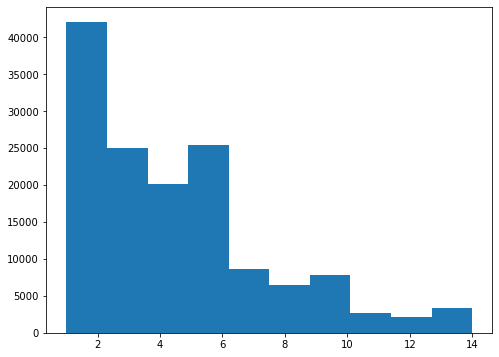

In [18]:
plt.figure(figsize=(8,6))
plt.hist(df['time_in_hospital']) # Not a Normal Distribution.

(array([1.4144e+05, 1.5000e+03, 2.7600e+02, 1.2800e+02, 2.9000e+01,
        2.2000e+01, 9.0000e+00, 2.0000e+00, 1.3000e+01, 5.0000e+00]),
 array([ 0. ,  4.2,  8.4, 12.6, 16.8, 21. , 25.2, 29.4, 33.6, 37.8, 42. ]),
 <a list of 10 Patch objects>)

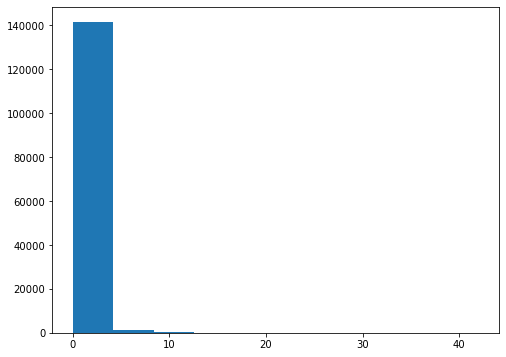

In [19]:
plt.figure(figsize=(8,6))
plt.hist(df['number_outpatient']) # right-skewed Normal Distribution.

(array([1.34319e+05, 6.59200e+03, 1.62800e+03, 5.13000e+02, 2.21000e+02,
        9.50000e+01, 3.60000e+01, 1.50000e+01, 2.00000e+00, 3.00000e+00]),
 array([ 0. ,  2.1,  4.2,  6.3,  8.4, 10.5, 12.6, 14.7, 16.8, 18.9, 21. ]),
 <a list of 10 Patch objects>)

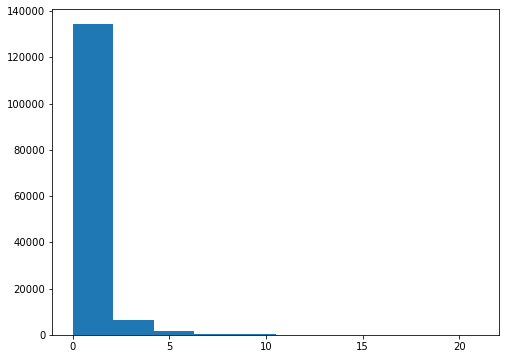

In [20]:
plt.figure(figsize=(8,6))
plt.hist(df['number_inpatient']) # right-skewed Normal Distribution.

(array([1.43132e+05, 2.32000e+02, 4.30000e+01, 6.00000e+00, 3.00000e+00,
        1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([ 0. ,  7.6, 15.2, 22.8, 30.4, 38. , 45.6, 53.2, 60.8, 68.4, 76. ]),
 <a list of 10 Patch objects>)

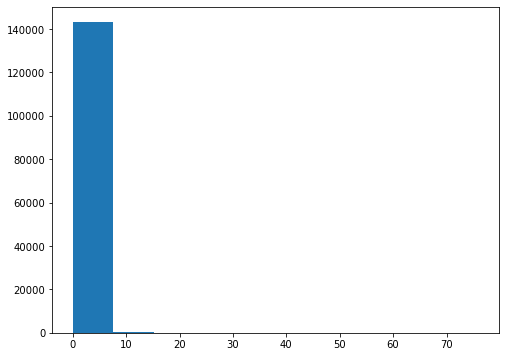

In [21]:
plt.figure(figsize=(8,6))
plt.hist(df['number_emergency']) # right-skewed Normal Distribution.

(array([1.4461e+04, 1.3772e+04, 3.0647e+04, 3.9583e+04, 2.9159e+04,
        1.2683e+04, 2.6990e+03, 3.8200e+02, 3.2000e+01, 6.0000e+00]),
 array([  1. ,  14.1,  27.2,  40.3,  53.4,  66.5,  79.6,  92.7, 105.8,
        118.9, 132. ]),
 <a list of 10 Patch objects>)

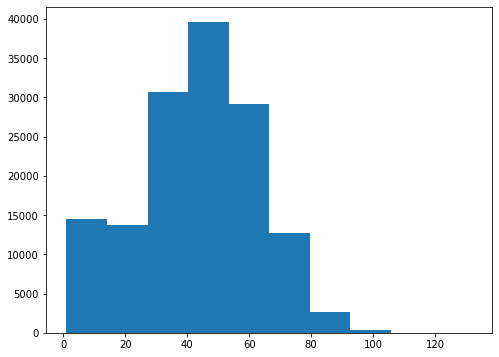

In [22]:
plt.figure(figsize=(8,6))
plt.hist(df['num_lab_procedures']) # Normal Distribution.

(array([1.6280e+03, 3.9160e+03, 2.4106e+04, 1.4170e+04, 3.0020e+04,
        6.9427e+04, 3.9000e+01, 1.0000e+01, 3.0000e+01, 7.8000e+01]),
 array([ 1. ,  2.5,  4. ,  5.5,  7. ,  8.5, 10. , 11.5, 13. , 14.5, 16. ]),
 <a list of 10 Patch objects>)

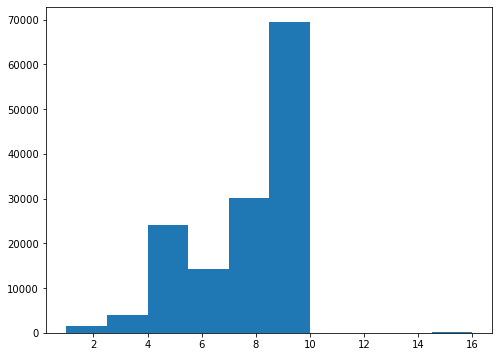

In [23]:
plt.figure(figsize=(8,6))
plt.hist(df['number_diagnoses']) # Not a Normal Distribution.

(array([1.8388e+04, 6.2033e+04, 4.1642e+04, 1.4657e+04, 4.2480e+03,
        1.4390e+03, 6.3700e+02, 2.9500e+02, 7.1000e+01, 1.4000e+01]),
 array([ 1.,  9., 17., 25., 33., 41., 49., 57., 65., 73., 81.]),
 <a list of 10 Patch objects>)

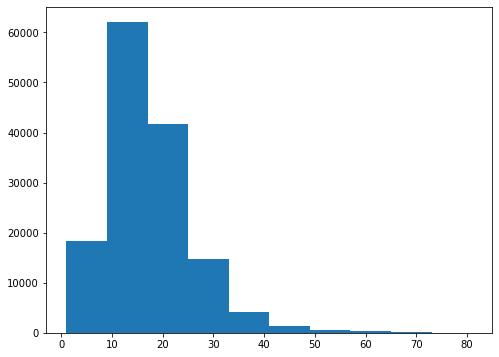

In [24]:
plt.figure(figsize=(8,6))
plt.hist(df['num_medications']) # right-skewed Normal Distribution.

(array([65788., 29039.,     0., 17788.,     0., 13252.,  5951.,     0.,
         4329.,  7277.]),
 array([0. , 0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. ]),
 <a list of 10 Patch objects>)

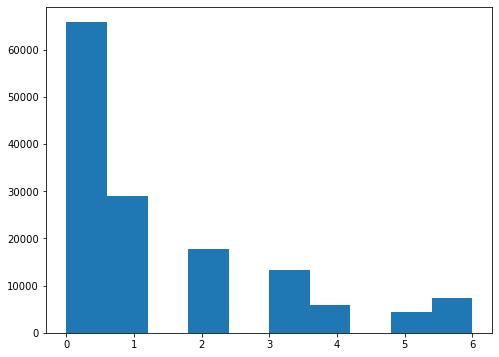

In [25]:
plt.figure(figsize=(8,6))
plt.hist(df['num_procedures']) # Not a Normal Distribution.

(array([1.43132e+05, 2.32000e+02, 4.30000e+01, 6.00000e+00, 3.00000e+00,
        1.00000e+00, 3.00000e+00, 1.00000e+00, 2.00000e+00, 1.00000e+00]),
 array([ 0. ,  7.6, 15.2, 22.8, 30.4, 38. , 45.6, 53.2, 60.8, 68.4, 76. ]),
 <a list of 10 Patch objects>)

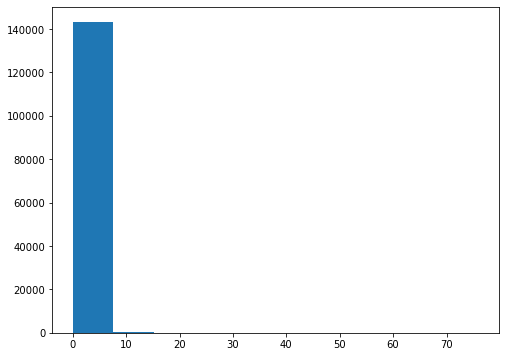

In [26]:
plt.figure(figsize=(8,6))
plt.hist(df['number_emergency']) # right-skewed Normal Distribution.

In [27]:
# Missing values
def check_null_values(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                           'percent_zero': df.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df 

In [28]:
null_df = check_null_values(df)
null_df

,columns,percent_null,percent_zero
encounter_id,encounter_id,0.000000,0.000000
patient_nbr,patient_nbr,0.000000,0.000000
race,race,2.307145,0.000000
gender,gender,0.000000,0.000000
age,age,0.000000,0.000000
weight,weight,97.000502,0.000000
admission_type_id,admission_type_id,0.000000,0.000000
discharge_disposition_id,discharge_disposition_id,0.000000,0.000000
admission_source_id,admission_source_id,0.000000,0.000000
time_in_hospital,time_in_hospital,0.000000,0.000000


In [29]:
# weight has highest null value . Also medical_specialty and payer_code have lot of null values.
# number_outpatient, number_inpatient, number_emergency and num_procedures have high percentages of zero's but that 
   # doesnot indicate the missing values as zero is one of the category of the fields.

In [30]:
for field in categotical_fields:
    print("The cardinality of the", field, "is : ", df[field].nunique())

The cardinality of the race is :  5
The cardinality of the gender is :  3
The cardinality of the admission_type_id is :  8
The cardinality of the discharge_disposition_id is :  26
The cardinality of the admission_source_id is :  17
The cardinality of the payer_code is :  17
The cardinality of the medical_specialty is :  72
The cardinality of the primary_diagnosis_code is :  716
The cardinality of the other_diagnosis_codes is :  19374
The cardinality of the ndc_code is :  251
The cardinality of the max_glu_serum is :  4
The cardinality of the A1Cresult is :  4
The cardinality of the change is :  2


In [31]:
len(set([x for sublist in df['other_diagnosis_codes'] for x in sublist.split('|')]))

849

In [32]:
# The fields with high cardinality  are 
    #primary_diagnosis_code which have code using ICD9 - CM code set, 
    #medical_specialty is an integer identifier of a specialty of the admitting physician, corresponding to 84 distinct values
    #discharge_disposition_id is an Integer identifier corresponding to 29 distinct values, for example, discharged to home, expired, and not available
    #other_diagnosis_codes is the secondary diagnosis codes using the ICD9 - CM code

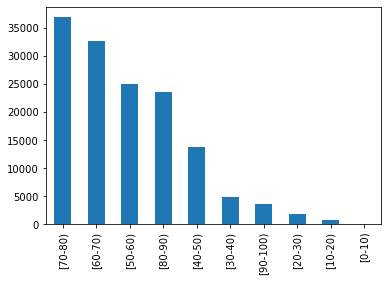

In [33]:
df['age'].value_counts().plot(kind='bar')

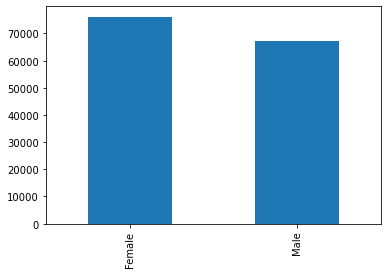

In [34]:
df['gender'].value_counts()[0:2].plot(kind='bar')

In [35]:
df['gender'].value_counts()[0:2]

Female    76185
Male      67234
Name: gender, dtype: int64

## Reduce Dimensionality of the NDC Code Feature

**Question 3**: NDC codes are a common format to represent the wide variety of drugs that are prescribed for patient care in the United States. The challenge is that there are many codes that map to the same or similar drug. You are provided with the ndc drug lookup file https://github.com/udacity/nd320-c1-emr-data-starter/blob/master/project/data_schema_references/ndc_lookup_table.csv derived from the National Drug Codes List site(https://ndclist.com/). Please use this file to come up with a way to reduce the dimensionality of this field and create a new field in the dataset called "generic_drug_name" in the output dataframe. 

In [36]:
#NDC code lookup file
ndc_code_path = "./medication_lookup_tables/final_ndc_lookup_table"
ndc_code_df = pd.read_csv(ndc_code_path)

In [37]:
ndc_code_df

,NDC_Code,Proprietary Name,Non-proprietary Name,Dosage Form,Route Name,Company Name,Product Type
0,0087-6060,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
1,0087-6063,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
2,0087-6064,Glucophage XR,Metformin Hydrochloride,"Tablet, Extended Release",Oral,Bristol-myers Squibb Company,Human Prescription Drug
3,0087-6070,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
4,0087-6071,Glucophage,Metformin Hydrochloride,"Tablet, Film Coated",Oral,Bristol-myers Squibb Company,Human Prescription Drug
...,...,...,...,...,...,...,...
264,0781-5635,Pioglitazone Hydrochloride And Glimepiride,Pioglitazone Hydrochloride And Glimepiride,Tablet,Oral,Sandoz Inc,Human Prescription Drug
265,64764-302,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
266,64764-304,Duetact,Pioglitazone And Glimepiride,Tablet,Oral,"Takeda Pharmaceuticals America, Inc.",Human Prescription Drug
267,66993-821,Pioglitazone And Glimepiride,Pioglitazone And Glimepiride,Tablet,Oral,Prasco Laboratories,Human Prescription Drug


In [38]:
len(ndc_code_df['NDC_Code'])

269

In [39]:
len(set([x.split('-')[0] for x in ndc_code_df['NDC_Code']]))

66

In [40]:
len(ndc_code_df['Non-proprietary Name'])

269

In [41]:
len(set(ndc_code_df['Non-proprietary Name']))

24

In [42]:
set(ndc_code_df['Non-proprietary Name'])

{'Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glipizide And Metformin Hcl',
 'Glipizide And Metformin Hydrochloride',
 'Glyburide',
 'Glyburide And Metformin Hydrochloride',
 'Glyburide-metformin Hydrochloride',
 'Human Insulin',
 'Insulin Human',
 'Metformin Hcl',
 'Metformin Hydrochloride',
 'Miglitol',
 'Nateglinide',
 'Pioglitazole And Metformin Hydrochloride',
 'Pioglitazone',
 'Pioglitazone And Glimepiride',
 'Pioglitazone And Metformin',
 'Pioglitazone Hcl And Metformin Hcl',
 'Pioglitazone Hydrochloride And Glimepiride',
 'Repaglinide',
 'Rosiglitazone Maleate',
 'Tolazamide',
 'Tolbutamide'}

In [43]:
df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143419,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,38,590|296,1,0,0,53,13,9,0,47918-902,None,None,Ch,NO
143420,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO
143421,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO
143422,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,47918-902,None,None,Ch,NO


In [44]:
'''
grouped_df = pd.DataFrame(ndc_code_df.groupby('Non-proprietary Name')['NDC_Code'].apply(list)).reset_index()

ndc_code_grouped_dict = dict(zip(grouped_df['Non-proprietary Name'], grouped_df['NDC_Code']))

df['generic_drug_name'] = ''

for name, code in ndc_code_grouped_dict.items():
    df.loc[df['ndc_code'].isin(code), 'generic_drug_name'] = name
    
reduce_dim_df = df
'''

df_new = pd.merge(df, ndc_code_df[['NDC_Code', 'Non-proprietary Name']],
                      how="left",
                      left_on='ndc_code',
                      right_on='NDC_Code')
df_new.rename(columns={"Non-proprietary Name": "generic_drug_name"}, inplace=True)
reduce_dim_df = df_new

In [45]:
reduce_dim_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name
0,2278392,8222157,Caucasian,Female,[0-10),NaN,6,25,1,1,NaN,Pediatrics-Endocrinology,250.83,?|?,0,0,0,41,1,1,0,NaN,None,None,No,NO,NaN,NaN
1,149190,55629189,Caucasian,Female,[10-20),NaN,1,1,7,3,NaN,NaN,276,250.01|255,0,0,0,59,9,18,0,68071-1701,None,None,Ch,>30,68071-1701,Human Insulin
2,64410,86047875,AfricanAmerican,Female,[20-30),NaN,1,1,7,2,NaN,NaN,648,250|V27,2,1,0,11,6,13,5,0378-1110,None,None,No,NO,0378-1110,Glipizide
3,500364,82442376,Caucasian,Male,[30-40),NaN,1,1,7,2,NaN,NaN,8,250.43|403,0,0,0,44,7,16,1,68071-1701,None,None,Ch,NO,68071-1701,Human Insulin
4,16680,42519267,Caucasian,Male,[40-50),NaN,1,1,7,1,NaN,NaN,197,157|250,0,0,0,51,5,8,0,0049-4110,None,None,Ch,NO,0049-4110,Glipizide
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143477,443854148,41088789,Caucasian,Male,[70-80),NaN,1,1,7,1,MC,NaN,38,590|296,1,0,0,53,13,9,0,47918-902,None,None,Ch,NO,47918-902,Insulin Human
143478,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0049-4110,None,None,Ch,NO,0049-4110,Glipizide
143479,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,0781-5421,None,None,Ch,NO,0781-5421,Pioglitazone
143480,443857166,31693671,Caucasian,Female,[80-90),NaN,2,3,7,10,MC,Surgery-General,996,285|998,0,1,0,45,9,21,2,47918-902,None,None,Ch,NO,47918-902,Insulin Human


In [46]:
#from student_utils import reduce_dimension_ndc

#def reduce_dimension_ndc(df, ndc_code_df):
    #ndc_code_df.groupby('Non-proprietary Name')['NDC_Code'].apply(list)

In [47]:
#reduce_dim_df = reduce_dimension_ndc(df, ndc_code_df)

In [48]:
# Number of unique values should be less for the new output field
assert df['ndc_code'].nunique() > reduce_dim_df['generic_drug_name'].nunique()

In [49]:
df['ndc_code'].nunique()

251

In [50]:
reduce_dim_df['generic_drug_name'].nunique()

22

## Select First Encounter for each Patient 

**Question 4**: In order to simplify the aggregation of data for the model, we will only select the first encounter for each patient in the dataset. This is to reduce the risk of data leakage of future patient encounters and to reduce complexity of the data transformation and modeling steps. We will assume that sorting in numerical order on the encounter_id provides the time horizon for determining which encounters come before and after another.

In [51]:
#from student_utils import select_first_encounter
#first_encounter_df = select_first_encounter(reduce_dim_df)

In [52]:
unique_patients = list(set(reduce_dim_df['patient_nbr']))

In [53]:
unique_encounters = sorted(list(set(reduce_dim_df['encounter_id'])))

In [54]:
sort_encounter_df = reduce_dim_df.sort_values(by = 'encounter_id').reset_index(drop=True)

In [55]:
each_patient_first_encounter = []
for patient_id in unique_patients:
    each_patient_first_encounter.append(sort_encounter_df[sort_encounter_df['patient_nbr'] == patient_id].iloc[0])

In [56]:
first_encounter_df = pd.concat(each_patient_first_encounter, axis=1)

In [57]:
first_encounter_df = first_encounter_df.T

In [58]:
first_encounter_df = first_encounter_df.reset_index(drop=True)

In [59]:
first_encounter_df.head()

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name
0,145090254,33947649,Caucasian,Female,[70-80),NaN,5,6,1,9,MC,NaN,486,491|578,0,0,0,55,9,25,1,47918-902,None,Norm,No,>30,47918-902,Insulin Human
1,169306476,92667906,Caucasian,Female,[80-90),NaN,1,1,2,1,NaN,NaN,465,276|401,0,0,0,43,9,12,0,51655-120,None,None,No,<30,51655-120,Glimepiride
2,39495408,82706436,Caucasian,Male,[50-60),NaN,3,1,1,7,NaN,NaN,V57,799|567,0,1,0,74,9,22,4,47918-891,None,None,Ch,NO,47918-891,Insulin Human
3,41640720,83623941,AfricanAmerican,Female,[30-40),NaN,1,1,7,2,NaN,NaN,250.13,311|401,0,1,3,71,7,13,1,47918-898,None,None,Ch,>30,47918-898,Insulin Human
4,339577844,128319494,NaN,Male,[80-90),NaN,2,3,1,3,NaN,NaN,725,38|599,0,0,1,53,9,11,0,68071-1701,None,None,Ch,NO,68071-1701,Human Insulin


In [60]:
# unique patients in transformed dataset
unique_patients = first_encounter_df['patient_nbr'].nunique()
print("Number of unique patients:{}".format(unique_patients))

# unique encounters in transformed dataset
unique_encounters = first_encounter_df['encounter_id'].nunique()
print("Number of unique encounters:{}".format(unique_encounters))

original_unique_patient_number = reduce_dim_df['patient_nbr'].nunique()
print("original_unique_patient_number:", original_unique_patient_number)
# number of unique patients should be equal to the number of unique encounters and patients in the final dataset
assert original_unique_patient_number == unique_patients
assert original_unique_patient_number == unique_encounters
print("Tests passed!!")

Number of unique patients:71518
Number of unique encounters:71518
original_unique_patient_number: 71518
Tests passed!!


## Aggregate Dataset to Right Level for Modeling 

In order to provide a broad scope of the steps and to prevent students from getting stuck with data transformations, we have selected the aggregation columns and provided a function to build the dataset at the appropriate level. The 'aggregate_dataset" function that you can find in the 'utils.py' file can take the preceding dataframe with the 'generic_drug_name' field and transform the data appropriately for the project. 

To make it simpler for students, we are creating dummy columns for each unique generic drug name and adding those are input features to the model. There are other options for data representation but this is out of scope for the time constraints of the course.

In [61]:
exclusion_list = ['generic_drug_name']
grouping_field_list = [c for c in first_encounter_df.columns if c not in exclusion_list]
agg_drug_df, ndc_col_list = aggregate_dataset(first_encounter_df, grouping_field_list, 'generic_drug_name')

/home/workspace/starter_code/utils.py:10: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  array_field].apply(lambda x: x[array_field].values.tolist()).reset_index().rename(columns={


In [62]:
grouping_field_list

['encounter_id',
 'patient_nbr',
 'race',
 'gender',
 'age',
 'weight',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'medical_specialty',
 'primary_diagnosis_code',
 'other_diagnosis_codes',
 'number_outpatient',
 'number_inpatient',
 'number_emergency',
 'num_lab_procedures',
 'number_diagnoses',
 'num_medications',
 'num_procedures',
 'ndc_code',
 'max_glu_serum',
 'A1Cresult',
 'change',
 'readmitted',
 'NDC_Code']

In [63]:
ndc_col_list

['Acarbose',
 'Glimepiride',
 'Glipizide',
 'Glyburide',
 'Human_Insulin',
 'Insulin_Human',
 'Metformin_Hcl',
 'Metformin_Hydrochloride',
 'Nateglinide',
 'Pioglitazone',
 'Repaglinide',
 'Rosiglitazone_Maleate']

In [64]:
agg_drug_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glyburide,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate
0,88792836,100654011,Caucasian,Female,[70-80),[75-100),3,3,1,10,UN,Surgery-General,715,402|428,1,3,1,65,9,28,1,0049-4110,None,None,Ch,<30,0049-4110,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0
1,88986678,58682736,Caucasian,Male,[80-90),[50-75),1,11,5,6,UN,Family/GeneralPractice,250.2,780|403,0,0,0,73,9,16,0,68071-1701,None,None,No,NO,68071-1701,[Human Insulin],0,0,0,0,1,0,0,0,0,0,0,0
2,89032962,69250302,Caucasian,Male,[60-70),[100-125),1,1,7,2,CP,Cardiology,414,411|401,0,0,0,58,9,12,3,0781-5422,None,None,No,>30,0781-5422,[Pioglitazone],0,0,0,0,0,0,0,0,0,1,0,0
3,89277516,30950811,Caucasian,Male,[50-60),[100-125),3,1,1,2,BC,Surgery-General,196,199|250,0,0,0,5,7,11,4,0093-8342,None,None,No,>30,0093-8342,[Glyburide],0,0,0,1,0,0,0,0,0,0,0,0
4,89307582,58763808,Caucasian,Female,[70-80),[75-100),1,3,7,10,MC,InternalMedicine,250.4,403|276,0,0,0,63,9,20,0,0591-0460,None,None,No,<30,0591-0460,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,433101896,111222522,Caucasian,Female,[70-80),[50-75),1,1,7,8,MC,Family/GeneralPractice,410,998|414,3,0,0,87,9,46,6,0049-4110,None,>8,Ch,>30,0049-4110,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0
587,436191524,90853668,Caucasian,Male,[90-100),[50-75),3,1,1,3,CM,Cardiology,410,250|427,0,0,0,69,7,7,0,0093-7212,None,None,Ch,NO,0093-7212,[Metformin Hydrochloride],0,0,0,0,0,0,0,1,0,0,0,0
588,436721264,123812618,AfricanAmerican,Male,[70-80),[75-100),1,1,7,1,MC,InternalMedicine,584,403|438,0,0,0,69,9,20,1,47918-902,None,None,No,NO,47918-902,[Insulin Human],0,0,0,0,0,1,0,0,0,0,0,0
589,437309498,52653654,Caucasian,Male,[60-70),[100-125),1,1,7,7,BC,Surgery-General,552,250|?,1,0,0,54,2,14,4,0093-7212,None,None,No,NO,0093-7212,[Metformin Hydrochloride],0,0,0,0,0,0,0,1,0,0,0,0


In [65]:
print(len(agg_drug_df))
print(agg_drug_df['patient_nbr'].nunique())
print(agg_drug_df['encounter_id'].nunique())

assert len(agg_drug_df) == agg_drug_df['patient_nbr'].nunique() == agg_drug_df['encounter_id'].nunique()

591
591
591


## Prepare Fields and Cast Dataset 

### Feature Selection

**Question 5**: After you have aggregated the dataset to the right level, we can do feature selection (we will include the ndc_col_list, dummy column features too). In the block below, please select the categorical and numerical features that you will use for the model, so that we can create a dataset subset. 

For the payer_code and weight fields, please provide whether you think we should include/exclude the field in our model and give a justification/rationale for this based off of the statistics of the data. Feel free to use visualizations or summary statistics to support your choice.

In [66]:
# Missing values
def check_null_values(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                           'percent_zero': df.isin([0]).sum() * 100 / len(df)                           } )
    return null_df 

In [67]:
updated_cols = [col for col in agg_drug_df.columns if col != 'generic_drug_name_array']
agg_drug_df_ = agg_drug_df[updated_cols]

In [68]:
check_null_values(agg_drug_df_)

,columns,percent_null,percent_zero
encounter_id,encounter_id,0.0,0.000000
patient_nbr,patient_nbr,0.0,0.000000
race,race,0.0,0.000000
gender,gender,0.0,0.000000
age,age,0.0,0.000000
weight,weight,0.0,0.000000
admission_type_id,admission_type_id,0.0,0.000000
discharge_disposition_id,discharge_disposition_id,0.0,0.000000
admission_source_id,admission_source_id,0.0,0.000000
time_in_hospital,time_in_hospital,0.0,0.000000


In [69]:
# We cannot include numerical fields  payer_code and weight fields for the modelling as they have high percentage of zeros.


In [70]:
'''
Please update the list to include the features you think are appropriate for the model 
and the field that we will be using to train the model. There are three required demographic features for the model 
and I have inserted a list with them already in the categorical list. 
These will be required for later steps when analyzing data splits and model biases.
'''
required_demo_col_list = ['race', 'gender', 'age']
# student_categorical_col_list = [ "feature_A", "feature_B", .... ] + required_demo_col_list + ndc_col_list
# student_numerical_col_list = [ "feature_A", "feature_B", .... ]
# PREDICTOR_FIELD = ''

'''
numerical_fields = ['number_outpatient', 'number_inpatient', 
                    'number_emergency', 'num_lab_procedures', 'number_diagnoses', 'num_medications',
                    'num_procedures']
'''
numerical_fields = ['num_lab_procedures', 'number_diagnoses', 'num_medications']

categotical_fields = ['race', 'gender', 'age', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
                      'medical_specialty', 'primary_diagnosis_code',
                     'ndc_code', 'max_glu_serum', 'A1Cresult', 'change', 'readmitted'] + ndc_col_list

PREDICTOR_FIELD = 'time_in_hospital'

In [71]:
agg_drug_df

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,primary_diagnosis_code,other_diagnosis_codes,number_outpatient,number_inpatient,number_emergency,num_lab_procedures,number_diagnoses,num_medications,num_procedures,ndc_code,max_glu_serum,A1Cresult,change,readmitted,NDC_Code,generic_drug_name_array,Acarbose,Glimepiride,Glipizide,Glyburide,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate
0,88792836,100654011,Caucasian,Female,[70-80),[75-100),3,3,1,10,UN,Surgery-General,715,402|428,1,3,1,65,9,28,1,0049-4110,None,None,Ch,<30,0049-4110,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0
1,88986678,58682736,Caucasian,Male,[80-90),[50-75),1,11,5,6,UN,Family/GeneralPractice,250.2,780|403,0,0,0,73,9,16,0,68071-1701,None,None,No,NO,68071-1701,[Human Insulin],0,0,0,0,1,0,0,0,0,0,0,0
2,89032962,69250302,Caucasian,Male,[60-70),[100-125),1,1,7,2,CP,Cardiology,414,411|401,0,0,0,58,9,12,3,0781-5422,None,None,No,>30,0781-5422,[Pioglitazone],0,0,0,0,0,0,0,0,0,1,0,0
3,89277516,30950811,Caucasian,Male,[50-60),[100-125),3,1,1,2,BC,Surgery-General,196,199|250,0,0,0,5,7,11,4,0093-8342,None,None,No,>30,0093-8342,[Glyburide],0,0,0,1,0,0,0,0,0,0,0,0
4,89307582,58763808,Caucasian,Female,[70-80),[75-100),1,3,7,10,MC,InternalMedicine,250.4,403|276,0,0,0,63,9,20,0,0591-0460,None,None,No,<30,0591-0460,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,433101896,111222522,Caucasian,Female,[70-80),[50-75),1,1,7,8,MC,Family/GeneralPractice,410,998|414,3,0,0,87,9,46,6,0049-4110,None,>8,Ch,>30,0049-4110,[Glipizide],0,0,1,0,0,0,0,0,0,0,0,0
587,436191524,90853668,Caucasian,Male,[90-100),[50-75),3,1,1,3,CM,Cardiology,410,250|427,0,0,0,69,7,7,0,0093-7212,None,None,Ch,NO,0093-7212,[Metformin Hydrochloride],0,0,0,0,0,0,0,1,0,0,0,0
588,436721264,123812618,AfricanAmerican,Male,[70-80),[75-100),1,1,7,1,MC,InternalMedicine,584,403|438,0,0,0,69,9,20,1,47918-902,None,None,No,NO,47918-902,[Insulin Human],0,0,0,0,0,1,0,0,0,0,0,0
589,437309498,52653654,Caucasian,Male,[60-70),[100-125),1,1,7,7,BC,Surgery-General,552,250|?,1,0,0,54,2,14,4,0093-7212,None,None,No,NO,0093-7212,[Metformin Hydrochloride],0,0,0,0,0,0,0,1,0,0,0,0


In [72]:
def select_model_features(df, categorical_col_list, numerical_col_list, PREDICTOR_FIELD, grouping_key='patient_nbr'):
    selected_col_list = [grouping_key] + [PREDICTOR_FIELD] + categorical_col_list + numerical_col_list   
    return agg_drug_df[selected_col_list]


In [73]:
selected_features_df = select_model_features(agg_drug_df, categotical_fields, numerical_fields,
                                            PREDICTOR_FIELD)

### Preprocess Dataset - Casting and Imputing  

We will cast and impute the dataset before splitting so that we do not have to repeat these steps across the splits in the next step. For imputing, there can be deeper analysis into which features to impute and how to impute but for the sake of time, we are taking a general strategy of imputing zero for only numerical features. 

OPTIONAL: What are some potential issues with this approach? Can you recommend a better way and also implement it?

In [74]:
processed_df = preprocess_df(selected_features_df, categotical_fields, 
        numerical_fields, PREDICTOR_FIELD, categorical_impute_value='nan', numerical_impute_value=0)

/home/workspace/starter_code/utils.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[predictor] = df[predictor].astype(float)
/home/workspace/starter_code/utils.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[c] = cast_df(df, c, d_type=str)
/home/workspace/starter_code/utils.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

In [75]:
processed_df

,patient_nbr,time_in_hospital,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,medical_specialty,primary_diagnosis_code,ndc_code,max_glu_serum,A1Cresult,change,readmitted,Acarbose,Glimepiride,Glipizide,Glyburide,Human_Insulin,Insulin_Human,Metformin_Hcl,Metformin_Hydrochloride,Nateglinide,Pioglitazone,Repaglinide,Rosiglitazone_Maleate,num_lab_procedures,number_diagnoses,num_medications
0,100654011,10.0,Caucasian,Female,[70-80),3,3,1,Surgery-General,715,0049-4110,None,None,Ch,<30,0,0,1,0,0,0,0,0,0,0,0,0,65,9,28
1,58682736,6.0,Caucasian,Male,[80-90),1,11,5,Family/GeneralPractice,250.2,68071-1701,None,None,No,NO,0,0,0,0,1,0,0,0,0,0,0,0,73,9,16
2,69250302,2.0,Caucasian,Male,[60-70),1,1,7,Cardiology,414,0781-5422,None,None,No,>30,0,0,0,0,0,0,0,0,0,1,0,0,58,9,12
3,30950811,2.0,Caucasian,Male,[50-60),3,1,1,Surgery-General,196,0093-8342,None,None,No,>30,0,0,0,1,0,0,0,0,0,0,0,0,5,7,11
4,58763808,10.0,Caucasian,Female,[70-80),1,3,7,InternalMedicine,250.4,0591-0460,None,None,No,<30,0,0,1,0,0,0,0,0,0,0,0,0,63,9,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,111222522,8.0,Caucasian,Female,[70-80),1,1,7,Family/GeneralPractice,410,0049-4110,None,>8,Ch,>30,0,0,1,0,0,0,0,0,0,0,0,0,87,9,46
587,90853668,3.0,Caucasian,Male,[90-100),3,1,1,Cardiology,410,0093-7212,None,None,Ch,NO,0,0,0,0,0,0,0,1,0,0,0,0,69,7,7
588,123812618,1.0,AfricanAmerican,Male,[70-80),1,1,7,InternalMedicine,584,47918-902,None,None,No,NO,0,0,0,0,0,1,0,0,0,0,0,0,69,9,20
589,52653654,7.0,Caucasian,Male,[60-70),1,1,7,Surgery-General,552,0093-7212,None,None,No,NO,0,0,0,0,0,0,0,1,0,0,0,0,54,2,14


## Split Dataset into Train, Validation, and Test Partitions

**Question 6**: In order to prepare the data for being trained and evaluated by a deep learning model, we will split the dataset into three partitions, with the validation partition used for optimizing the model hyperparameters during training. One of the key parts is that we need to be sure that the data does not accidently leak across partitions.

Please complete the function below to split the input dataset into three partitions(train, validation, test) with the following requirements.
- Approximately 60%/20%/20%  train/validation/test split
- Randomly sample different patients into each data partition
- **IMPORTANT** Make sure that a patient's data is not in more than one partition, so that we can avoid possible data leakage.
- Make sure that the total number of unique patients across the splits is equal to the total number of unique patients in the original dataset
- Total number of rows in original dataset = sum of rows across all three dataset partitions

In [76]:
#from student_utils import patient_dataset_splitter
#d_train, d_val, d_test = patient_dataset_splitter(processed_df, 'patient_nbr')

train_percentage = 0.6
valid_percentage = 0.2
test_percentage = 0.2

unique_patient_ids = list(set(processed_df['patient_nbr']))

random.shuffle(unique_patient_ids)

train = unique_patient_ids[:round(len(unique_patient_ids)*train_percentage)]
valid = unique_patient_ids[round(len(unique_patient_ids)*train_percentage):round(len(unique_patient_ids)*(train_percentage + valid_percentage))]
test = unique_patient_ids[round(len(unique_patient_ids)*(train_percentage + valid_percentage)):]

d_train = processed_df[processed_df['patient_nbr'].isin(train)]
d_val = processed_df[processed_df['patient_nbr'].isin(valid)]
d_test = processed_df[processed_df['patient_nbr'].isin(test)]

In [77]:
(d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()

True

In [78]:
len(d_train) + len(d_val) + len(d_test) == len(processed_df)

True

In [79]:
len(set(d_train['patient_nbr'].unique()).intersection(set(d_val['patient_nbr'].unique()))) == 0

True

In [80]:
len(set(d_val['patient_nbr'].unique()).intersection(set(d_test['patient_nbr'].unique()))) == 0

True

In [81]:
len(set(d_train['patient_nbr'].unique()).intersection(set(d_test['patient_nbr'].unique()))) == 0

True

In [82]:
assert len(d_train) + len(d_val) + len(d_test) == len(processed_df)
print("Test passed for number of total rows equal!")

Test passed for number of total rows equal!


In [83]:
assert (d_train['patient_nbr'].nunique() + d_val['patient_nbr'].nunique() + d_test['patient_nbr'].nunique()) == agg_drug_df['patient_nbr'].nunique()
print("Test passed for number of unique patients being equal!")

Test passed for number of unique patients being equal!


## Demographic Representation Analysis of Split

After the split, we should check to see the distribution of key features/groups and make sure that there is representative samples across the partitions. The show_group_stats_viz function in the utils.py file can be used to group and visualize different groups and dataframe partitions.

### Label Distribution Across Partitions

Below you can see the distributution of the label across your splits. Are the histogram distribution shapes similar across partitions?

time_in_hospital
1.0      44
2.0      95
3.0     126
4.0      99
5.0      57
6.0      47
7.0      37
8.0      29
9.0      18
10.0     10
11.0      8
12.0     10
13.0      9
14.0      2
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


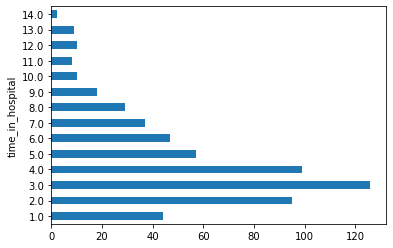

In [84]:
show_group_stats_viz(processed_df, PREDICTOR_FIELD)

time_in_hospital
1.0     23
2.0     65
3.0     80
4.0     45
5.0     35
6.0     25
7.0     25
8.0     20
9.0     10
10.0     6
11.0     7
12.0     7
13.0     6
14.0     1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


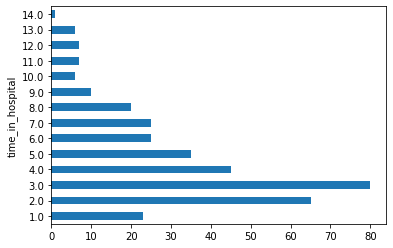

In [85]:
show_group_stats_viz(d_train, PREDICTOR_FIELD)

time_in_hospital
1.0      9
2.0     15
3.0     28
4.0     23
5.0     14
6.0     13
7.0      5
8.0      1
9.0      4
10.0     2
11.0     1
12.0     1
13.0     1
14.0     1
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


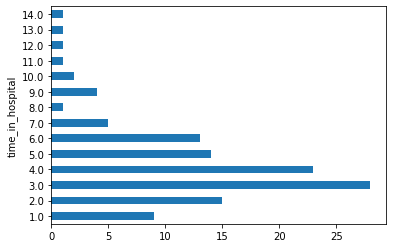

In [86]:
show_group_stats_viz(d_test, PREDICTOR_FIELD)

## Demographic Group Analysis

We should check that our partitions/splits of the dataset are similar in terms of their demographic profiles. Below you can see how we might visualize and analyze the full dataset vs. the partitions.

gender
Female    299
Male      292
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


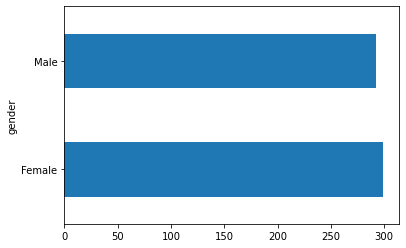

In [87]:
# Full dataset before splitting
patient_demo_features = ['race', 'gender', 'age', 'patient_nbr']
patient_group_analysis_df = processed_df[patient_demo_features].groupby('patient_nbr').head(1).reset_index(drop=True)
show_group_stats_viz(patient_group_analysis_df, 'gender')

gender
Female    174
Male      181
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


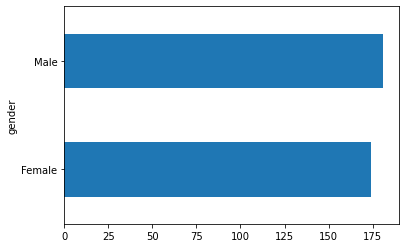

In [88]:
# Training partition
show_group_stats_viz(d_train, 'gender')

gender
Female    63
Male      55
dtype: int64
AxesSubplot(0.125,0.125;0.775x0.755)


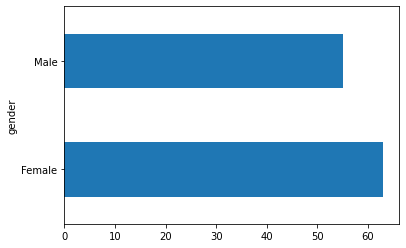

In [89]:
# Test partition
show_group_stats_viz(d_test, 'gender')

In [90]:
# Missing values
def check_null_values(df):
    null_df = pd.DataFrame({'columns': df.columns, 
                            'percent_null': df.isnull().sum() * 100 / len(df), 
                           'percent_zero': df.isin([0]).sum() * 100 / len(df)
                           } )
    return null_df 

In [91]:
check_null_values(d_train)

,columns,percent_null,percent_zero
patient_nbr,patient_nbr,0.0,0.0
time_in_hospital,time_in_hospital,0.0,0.0
race,race,0.0,0.0
gender,gender,0.0,0.0
age,age,0.0,0.0
admission_type_id,admission_type_id,0.0,0.0
discharge_disposition_id,discharge_disposition_id,0.0,0.0
admission_source_id,admission_source_id,0.0,0.0
medical_specialty,medical_specialty,0.0,0.0
primary_diagnosis_code,primary_diagnosis_code,0.0,0.0


In [92]:
check_null_values(d_val)

,columns,percent_null,percent_zero
patient_nbr,patient_nbr,0.0,0.0
time_in_hospital,time_in_hospital,0.0,0.0
race,race,0.0,0.0
gender,gender,0.0,0.0
age,age,0.0,0.0
admission_type_id,admission_type_id,0.0,0.0
discharge_disposition_id,discharge_disposition_id,0.0,0.0
admission_source_id,admission_source_id,0.0,0.0
medical_specialty,medical_specialty,0.0,0.0
primary_diagnosis_code,primary_diagnosis_code,0.0,0.0


In [93]:
check_null_values(d_test)

,columns,percent_null,percent_zero
patient_nbr,patient_nbr,0.0,0.0
time_in_hospital,time_in_hospital,0.0,0.0
race,race,0.0,0.0
gender,gender,0.0,0.0
age,age,0.0,0.0
admission_type_id,admission_type_id,0.0,0.0
discharge_disposition_id,discharge_disposition_id,0.0,0.0
admission_source_id,admission_source_id,0.0,0.0
medical_specialty,medical_specialty,0.0,0.0
primary_diagnosis_code,primary_diagnosis_code,0.0,0.0


## Convert Dataset Splits to TF Dataset

We have provided you the function to convert the Pandas dataframe to TF tensors using the TF Dataset API. 
Please note that this is not a scalable method and for larger datasets, the 'make_csv_dataset' method is recommended -https://www.tensorflow.org/api_docs/python/tf/data/experimental/make_csv_dataset.

In [94]:
def df_to_dataset(df, predictor,  batch_size=32):
    df = df.copy()
    labels = df.pop(predictor)
    ds = tf.data.Dataset.from_tensor_slices((dict(df), labels))
    ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    return ds

In [95]:
# Convert dataset from Pandas dataframes to TF dataset
batch_size = 128
diabetes_train_ds = df_to_dataset(d_train, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_val_ds = df_to_dataset(d_val, PREDICTOR_FIELD, batch_size=batch_size)
diabetes_test_ds = df_to_dataset(d_test, PREDICTOR_FIELD, batch_size=batch_size)

In [96]:
# We use this sample of the dataset to show transformations later
diabetes_batch = next(iter(diabetes_train_ds))[0]
def demo(feature_column, example_batch):
    feature_layer = layers.DenseFeatures(feature_column)
    print(feature_layer(example_batch))

# 4. Create Categorical Features with TF Feature Columns

## Build Vocabulary for Categorical Features

Before we can create the TF categorical features, we must first create the vocab files with the unique values for a given field that are from the **training** dataset. Below we have provided a function that you can use that only requires providing the pandas train dataset partition and the list of the categorical columns in a list format. The output variable 'vocab_file_list' will be a list of the file paths that can be used in the next step for creating the categorical features.

In [97]:
# build vocab for categorical features
if 'vocab' not in os.listdir():
    os.makedirs('vocab')
def write_vocabulary_file(vocab_list, field_name, default_value, vocab_dir='./vocab/'):
    output_file_path = os.path.join(vocab_dir, str(field_name) + "_vocab.txt")
    # put default value in first row as TF requires
    vocab_list = np.insert(vocab_list, 0, default_value, axis=0) 
    df = pd.DataFrame(vocab_list).to_csv(output_file_path, index=None, header=None)
    return output_file_path

def build_vocab_files(df, categorical_column_list, default_value='00'):
    vocab_files_list = []
    for c in categorical_column_list:
        v_file = write_vocabulary_file(df[c].unique(), c, default_value)
        print(v_file)
        vocab_files_list.append(v_file)
    return vocab_files_list

all_data = pd.concat([d_train, d_val, d_test])
#vocab_file_list = build_vocab_files(d_train, categotical_fields)
vocab_file_list = build_vocab_files(all_data, categotical_fields)

./vocab/race_vocab.txt
./vocab/gender_vocab.txt
./vocab/age_vocab.txt
./vocab/admission_type_id_vocab.txt
./vocab/discharge_disposition_id_vocab.txt
./vocab/admission_source_id_vocab.txt
./vocab/medical_specialty_vocab.txt
./vocab/primary_diagnosis_code_vocab.txt
./vocab/ndc_code_vocab.txt
./vocab/max_glu_serum_vocab.txt
./vocab/A1Cresult_vocab.txt
./vocab/change_vocab.txt
./vocab/readmitted_vocab.txt
./vocab/Acarbose_vocab.txt
./vocab/Glimepiride_vocab.txt
./vocab/Glipizide_vocab.txt
./vocab/Glyburide_vocab.txt
./vocab/Human_Insulin_vocab.txt
./vocab/Insulin_Human_vocab.txt
./vocab/Metformin_Hcl_vocab.txt
./vocab/Metformin_Hydrochloride_vocab.txt
./vocab/Nateglinide_vocab.txt
./vocab/Pioglitazone_vocab.txt
./vocab/Repaglinide_vocab.txt
./vocab/Rosiglitazone_Maleate_vocab.txt


In [98]:
vocab_file_list

['./vocab/race_vocab.txt',
 './vocab/gender_vocab.txt',
 './vocab/age_vocab.txt',
 './vocab/admission_type_id_vocab.txt',
 './vocab/discharge_disposition_id_vocab.txt',
 './vocab/admission_source_id_vocab.txt',
 './vocab/medical_specialty_vocab.txt',
 './vocab/primary_diagnosis_code_vocab.txt',
 './vocab/ndc_code_vocab.txt',
 './vocab/max_glu_serum_vocab.txt',
 './vocab/A1Cresult_vocab.txt',
 './vocab/change_vocab.txt',
 './vocab/readmitted_vocab.txt',
 './vocab/Acarbose_vocab.txt',
 './vocab/Glimepiride_vocab.txt',
 './vocab/Glipizide_vocab.txt',
 './vocab/Glyburide_vocab.txt',
 './vocab/Human_Insulin_vocab.txt',
 './vocab/Insulin_Human_vocab.txt',
 './vocab/Metformin_Hcl_vocab.txt',
 './vocab/Metformin_Hydrochloride_vocab.txt',
 './vocab/Nateglinide_vocab.txt',
 './vocab/Pioglitazone_vocab.txt',
 './vocab/Repaglinide_vocab.txt',
 './vocab/Rosiglitazone_Maleate_vocab.txt']

## Create Categorical Features with Tensorflow Feature Column API

**Question 7**: Using the vocab file list from above that was derived fromt the features you selected earlier, please create categorical features with the Tensorflow Feature Column API, https://www.tensorflow.org/api_docs/python/tf/feature_column. Below is a function to help guide you.

In [99]:
#from student_utils import create_tf_categorical_feature_cols
def create_tf_categorical_feature_cols(categorical_col):
    tf_category_list = []
    for filename in vocab_file_list:
        category =  filename.split('./vocab/')[1].split('_vocab.txt')[0]
        tf_category = tf.feature_column.categorical_column_with_vocabulary_file(
                category, filename, num_oov_buckets=1)
        category_one_hot = tf.feature_column.indicator_column(tf_category)
        tf_category_list.append(category_one_hot)
    return tf_category_list
tf_cat_col_list = create_tf_categorical_feature_cols(categotical_fields)

INFO:tensorflow:vocabulary_size = 5 in race is inferred from the number of elements in the vocabulary_file ./vocab/race_vocab.txt.
INFO:tensorflow:vocabulary_size = 3 in gender is inferred from the number of elements in the vocabulary_file ./vocab/gender_vocab.txt.
INFO:tensorflow:vocabulary_size = 10 in age is inferred from the number of elements in the vocabulary_file ./vocab/age_vocab.txt.
INFO:tensorflow:vocabulary_size = 5 in admission_type_id is inferred from the number of elements in the vocabulary_file ./vocab/admission_type_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 11 in discharge_disposition_id is inferred from the number of elements in the vocabulary_file ./vocab/discharge_disposition_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 7 in admission_source_id is inferred from the number of elements in the vocabulary_file ./vocab/admission_source_id_vocab.txt.
INFO:tensorflow:vocabulary_size = 8 in medical_specialty is inferred from the number of elements in the vocabulary

In [100]:
test_cat_var1 = tf_cat_col_list[0]
print("Example categorical field:\n{}".format(test_cat_var1))
demo(test_cat_var1, diabetes_batch)

Example categorical field:
IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='race', vocabulary_file='./vocab/race_vocab.txt', vocabulary_size=5, num_oov_buckets=1, dtype=tf.string, default_value=-1))
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
tf.Tensor(
[[0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0

In [101]:
diabetes_batch

{'patient_nbr': <tf.Tensor: shape=(128,), dtype=int32, numpy=
 array([ 93890061, 101132973,  73878543,  98802900,  20969919,  94783464,
         73392147,  59131863, 109527102,  88544232,  10865385,  78637509,
         54763974,  89608131,  88182144, 113452965,   4312467, 112653738,
           761670,  96584418,  92525355,  90818226,  69256188,  66976416,
         75618207,  42241986,  94037994,  80133525,  64778958,  21261294,
         91231434, 101233647,  25776972, 114508206,  64296630,  51672447,
         28177659,  65530926,  53829720,  97074369, 112115556,  91446426,
         57630609, 113896179,  85160916,  68925204,  88646436,   5396931,
         40153572,   5303844,  81229968, 109364517,  31004532,  62794638,
         87109101,  88298091,  60001884, 102420747,  99090900,  80895078,
         67461381,  80966655,  15244776, 110745081,  74720043, 100983141,
        113427171,  54115434,  72877500,  69640065,  98777394,  56220255,
         78098634,  77741667,  93379203,  80913897

In [102]:
test_cat_var1

IndicatorColumn(categorical_column=VocabularyFileCategoricalColumn(key='race', vocabulary_file='./vocab/race_vocab.txt', vocabulary_size=5, num_oov_buckets=1, dtype=tf.string, default_value=-1))

# 5. Create Numerical Features with TF Feature Columns

**Question 8**: Using the TF Feature Column API(https://www.tensorflow.org/api_docs/python/tf/feature_column/), please create normalized Tensorflow numeric features for the model. Try to use the z-score normalizer function below to help as well as the 'calculate_stats_from_train_data' function.

In [103]:
from student_utils import create_tf_numeric_feature

For simplicity the create_tf_numerical_feature_cols function below uses the same normalizer function across all features(z-score normalization) but if you have time feel free to analyze and adapt the normalizer based off the statistical distributions. You may find this as a good resource in determining which transformation fits best for the data https://developers.google.com/machine-learning/data-prep/transform/normalization.


In [104]:
import functools
def normalize_numeric_with_zscore(col, mean, std):
    return (col - mean)/std

def create_tf_numeric_feature(col, MEAN, STD):
    normalizer = functools.partial(normalize_numeric_with_zscore, mean=MEAN, std=STD)
    return tf.feature_column.numeric_column(
    key=col, default_value = 0, normalizer_fn=normalizer, dtype=tf.float64)

def calculate_stats_from_train_data(df, col):
    mean = df[col].describe()['mean']
    std = df[col].describe()['std']
    return mean, std

def create_tf_numerical_feature_cols(numerical_col_list, train_df):
    tf_numeric_col_list = []
    for c in numerical_col_list:
        mean, std = calculate_stats_from_train_data(train_df, c)
        tf_numeric_feature = create_tf_numeric_feature(c, mean, std)
        tf_numeric_col_list.append(tf_numeric_feature)
    return tf_numeric_col_list

In [105]:
tf_cont_col_list = create_tf_numerical_feature_cols(numerical_fields, d_train)

In [106]:
tf_cont_col_list

[NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7efe84edb560>, mean=52.267605633802816, std=20.17365131867932)),
 NumericColumn(key='number_diagnoses', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7efe84edb560>, mean=8.253521126760564, std=1.3374052567864698)),
 NumericColumn(key='num_medications', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7efe84edb560>, mean=17.577464788732396, std=7.545084776794155))]

In [107]:
test_cont_var1 = tf_cont_col_list[0]
print("Example continuous field:\n{}\n".format(test_cont_var1))
demo(test_cont_var1, diabetes_batch)

Example continuous field:
NumericColumn(key='num_lab_procedures', shape=(1,), default_value=(0,), dtype=tf.float64, normalizer_fn=functools.partial(<function normalize_numeric_with_zscore at 0x7efe84edb560>, mean=52.267605633802816, std=20.17365131867932))

tf.Tensor(
[[-2.1 ]
 [-0.95]
 [-0.3 ]
 [-0.65]
 [ 0.1 ]
 [ 0.15]
 [ 0.7 ]
 [ 1.2 ]
 [-0.55]
 [-0.25]
 [-1.05]
 [ 0.2 ]
 [-0.25]
 [-1.2 ]
 [ 1.5 ]
 [-0.1 ]
 [ 1.05]
 [-0.65]
 [-1.  ]
 [ 0.2 ]
 [-0.1 ]
 [-0.3 ]
 [ 0.2 ]
 [ 0.3 ]
 [-2.5 ]
 [ 1.3 ]
 [-1.  ]
 [ 1.35]
 [-0.15]
 [ 1.  ]
 [-1.15]
 [-1.7 ]
 [ 0.35]
 [-0.85]
 [ 0.8 ]
 [-0.25]
 [-1.15]
 [-1.  ]
 [ 0.6 ]
 [ 1.4 ]
 [ 0.6 ]
 [-0.3 ]
 [ 0.7 ]
 [-0.25]
 [ 0.15]
 [-0.6 ]
 [ 0.8 ]
 [-0.8 ]
 [ 0.7 ]
 [ 0.55]
 [ 0.2 ]
 [ 0.4 ]
 [-0.7 ]
 [ 0.1 ]
 [ 0.45]
 [ 1.05]
 [-0.15]
 [ 1.55]
 [ 0.65]
 [ 1.05]
 [ 0.65]
 [-1.1 ]
 [ 0.45]
 [ 0.85]
 [-0.6 ]
 [-0.7 ]
 [ 1.7 ]
 [ 1.  ]
 [ 1.1 ]
 [ 0.05]
 [ 0.7 ]
 [ 0.7 ]
 [-0.1 ]
 [-0.65]
 [ 0.55]
 [ 1.35]
 [ 1.1 ]
 [ 0.35]
 [-1.45]
 [ 0.85]
 [-1.5 ]
 [

# 6. Build Deep Learning Regression Model with Sequential API and TF Probability Layers

## Use DenseFeatures to combine features for model

Now that we have prepared categorical and numerical features using Tensorflow's Feature Column API, we can combine them into a dense vector representation for the model. Below we will create this new input layer, which we will call 'claim_feature_layer'.

In [108]:
claim_feature_columns = tf_cat_col_list + tf_cont_col_list
claim_feature_layer = tf.keras.layers.DenseFeatures(claim_feature_columns)

In [109]:
claim_feature_layer

## Build Sequential API Model from DenseFeatures and TF Probability Layers

Below we have provided some boilerplate code for building a model that connects the Sequential API, DenseFeatures, and Tensorflow Probability layers into a deep learning model. There are many opportunities to further optimize and explore different architectures through benchmarking and testing approaches in various research papers, loss and evaluation metrics, learning curves, hyperparameter tuning, TF probability layers, etc. Feel free to modify and explore as you wish.

**OPTIONAL**: Come up with a more optimal neural network architecture and hyperparameters. Share the process in discovering the architecture and hyperparameters.

In [110]:
def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2*n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
            tfp.distributions.Normal(loc=t[..., :n],
                                     scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])


def prior_trainable(kernel_size, bias_size=0, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
            tfp.distributions.Normal(loc=t, scale=1),
            reinterpreted_batch_ndims=1)),
    ])


In [126]:
def build_seq_prob_model(feature_layer):
    model = tf.keras.Sequential([
        feature_layer,
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(75, activation='relu'),
           tfp.layers.DenseVariational(1+1, posterior_mean_field, prior_trainable),        
        tfp.layers.DistributionLambda(            
            lambda t:tfp.distributions.Normal(loc=t[..., :1],
                                            scale=1e-3 + tf.math.softplus(0.1 * t[...,1:])
                                             )
        ),
    ])
    return model

def build_prob_model(train_ds, val_ds,  feature_layer,  epochs=5, loss_metric='mse'):
    model = build_seq_prob_model(feature_layer)
    negloglik = lambda y, rv_y: -rv_y.log_prob(y)
    loss = negloglik
    model.compile(optimizer='rmsprop', loss=loss, metrics=[loss_metric])
    history = model.fit(train_ds, validation_data=val_ds,
                        epochs=epochs)
    return model, history

In [150]:
#model, history = build_diabetes_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=15)
prob_model, history = build_prob_model(diabetes_train_ds, diabetes_val_ds,  claim_feature_layer,  epochs=1000)

Train for 3 steps, validate for 1 steps
Epoch 1/1000
3/3 [==============================] - 7s 2s/step - loss: 41.2350 - mse: 24.9944 - val_loss: 18.8625 - val_mse: 13.9682
Epoch 2/1000
3/3 [==============================] - 0s 75ms/step - loss: 40.1026 - mse: 40.4987 - val_loss: 12.1308 - val_mse: 14.8266
Epoch 3/1000
3/3 [==============================] - 0s 79ms/step - loss: 43.1560 - mse: 30.5454 - val_loss: 38.2703 - val_mse: 29.8734
Epoch 4/1000
3/3 [==============================] - 0s 81ms/step - loss: 30.9345 - mse: 45.1504 - val_loss: 58.1913 - val_mse: 36.2717
Epoch 5/1000
3/3 [==============================] - 0s 81ms/step - loss: 47.7118 - mse: 36.7320 - val_loss: 32.3407 - val_mse: 35.3747
Epoch 6/1000
3/3 [==============================] - 0s 83ms/step - loss: 37.7855 - mse: 36.2897 - val_loss: 21.6673 - val_mse: 29.8672
Epoch 7/1000
3/3 [==============================] - 0s 88ms/step - loss: 39.0419 - mse: 39.6215 - val_loss: 26.3380 - val_mse: 19.9067
Epoch 8/1000
3/3 

## Show Model Uncertainty Range with TF Probability

**Question 9**: Now that we have trained a model with TF Probability layers, we can extract the mean and standard deviation for each prediction. Please fill in the answer for the m and s variables below. The code for getting the predictions is provided for you below.

In [151]:
feature_list = categotical_fields + numerical_fields
diabetes_x_tst = dict(d_test[feature_list])
diabetes_yhat = prob_model(diabetes_x_tst)
preds = prob_model.predict(diabetes_test_ds)

In [152]:
preds

array([[ 3.9479809 ],
       [ 9.339556  ],
       [ 1.5702626 ],
       [ 3.225195  ],
       [ 4.380525  ],
       [ 1.3452219 ],
       [ 3.2401872 ],
       [ 0.92724186],
       [ 5.2312765 ],
       [ 2.1647613 ],
       [ 7.2280116 ],
       [ 9.298755  ],
       [ 1.6961772 ],
       [ 6.514257  ],
       [ 8.701736  ],
       [ 4.4909906 ],
       [11.048584  ],
       [ 0.70129776],
       [ 5.5599837 ],
       [ 3.08322   ],
       [ 5.279413  ],
       [-0.9837783 ],
       [ 6.824323  ],
       [ 6.1877704 ],
       [ 1.1165417 ],
       [ 1.5217873 ],
       [ 0.09106952],
       [ 1.9171077 ],
       [ 4.910459  ],
       [ 3.7671525 ],
       [ 3.673492  ],
       [ 2.8421893 ],
       [ 2.5745645 ],
       [ 3.595681  ],
       [ 2.720633  ],
       [ 5.9957943 ],
       [ 3.206953  ],
       [ 0.67304814],
       [ 6.6077323 ],
       [ 0.9092238 ],
       [ 4.777031  ],
       [ 8.614972  ],
       [ 1.9116242 ],
       [ 2.130081  ],
       [ 3.8129954 ],
       [ 3

In [153]:
diabetes_yhat.shape

TensorShape([118, 1])

In [154]:
#from student_utils import get_mean_std_from_preds
#m, s = get_mean_std_from_preds(diabetes_yhat)

m = diabetes_yhat.mean()
s = diabetes_yhat.stddev()

In [155]:
diabetes_yhat

<tfp.distributions.Normal 'sequential_4/distribution_lambda_4/Normal/' batch_shape=[118, 1] event_shape=[] dtype=float32>

In [156]:
m

<tf.Tensor: shape=(118, 1), dtype=float32, numpy=
array([[ 7.031042  ],
       [ 1.8379102 ],
       [ 2.0714536 ],
       [ 5.525654  ],
       [ 7.59379   ],
       [ 1.3762687 ],
       [ 7.091497  ],
       [ 3.7220016 ],
       [ 4.4723477 ],
       [ 3.3697069 ],
       [ 2.1106992 ],
       [ 1.6382682 ],
       [ 5.289447  ],
       [ 4.1168494 ],
       [ 1.2877988 ],
       [ 2.50719   ],
       [ 3.591934  ],
       [ 3.0867124 ],
       [ 3.4532163 ],
       [ 5.458859  ],
       [ 5.6976905 ],
       [ 1.8188145 ],
       [ 1.6312983 ],
       [ 6.9346604 ],
       [ 5.9844804 ],
       [ 6.0392227 ],
       [ 2.9228694 ],
       [ 6.059352  ],
       [ 1.46112   ],
       [ 4.669964  ],
       [ 2.2012682 ],
       [ 5.328644  ],
       [ 1.8511214 ],
       [ 4.065335  ],
       [ 1.486826  ],
       [ 1.7390747 ],
       [ 5.270198  ],
       [ 3.7916045 ],
       [ 1.9572201 ],
       [ 9.888033  ],
       [ 2.5508628 ],
       [ 2.649985  ],
       [ 0.1489346 ],
    

In [157]:
s

<tf.Tensor: shape=(118, 1), dtype=float32, numpy=
array([[1.0113219 ],
       [0.776833  ],
       [0.7901129 ],
       [0.91941756],
       [1.0118104 ],
       [0.7611161 ],
       [1.034806  ],
       [0.84569734],
       [0.859365  ],
       [0.8377097 ],
       [0.7857682 ],
       [0.76801264],
       [0.952496  ],
       [0.8953909 ],
       [0.77107126],
       [0.79162407],
       [0.8573261 ],
       [0.8301169 ],
       [0.83748657],
       [0.896544  ],
       [0.9582    ],
       [0.77474874],
       [0.7897159 ],
       [1.0201614 ],
       [0.9687738 ],
       [0.9804717 ],
       [0.8063538 ],
       [0.9409701 ],
       [0.7755196 ],
       [0.92617637],
       [0.7739381 ],
       [0.9330212 ],
       [0.76638794],
       [0.88024473],
       [0.7818806 ],
       [0.8186384 ],
       [0.9332808 ],
       [0.840221  ],
       [0.76840043],
       [1.1482493 ],
       [0.7909506 ],
       [0.8211233 ],
       [0.7346213 ],
       [0.88282174],
       [0.7747968 ],
     

## Show Prediction Output 

In [158]:
prob_outputs = {
    "pred": preds.flatten(),
    "actual_value": d_test['time_in_hospital'].values,
    "pred_mean": m.numpy().flatten(),
    "pred_std": s.numpy().flatten()
}
prob_output_df = pd.DataFrame(prob_outputs)

In [159]:
prob_output_df

,pred,actual_value,pred_mean,pred_std
0,3.947981,10.0,7.031042,1.011322
1,9.339556,3.0,1.837910,0.776833
2,1.570263,3.0,2.071454,0.790113
3,3.225195,7.0,5.525654,0.919418
4,4.380525,4.0,7.593790,1.011810
...,...,...,...,...
113,1.282787,2.0,2.310535,0.797473
114,2.511513,4.0,0.743176,0.738820
115,4.862531,2.0,1.662401,0.773118
116,2.623157,6.0,5.908879,0.965457


## Convert Regression Output to Classification Output for Patient Selection

**Question 10**: Given the output predictions, convert it to a binary label for whether the patient meets the time criteria or does not (HINT: use the mean prediction numpy array). The expected output is a numpy array with a 1 or 0 based off if the prediction meets or doesnt meet the criteria.

In [160]:
#from student_utils import get_student_binary_prediction
#student_binary_prediction = get_student_binary_prediction(prob_output_df, 'pred_mean')

student_binary_prediction = prob_output_df['pred_mean'].apply(lambda x: 1 if x>=5 else 0).to_numpy()

In [161]:
student_binary_prediction

array([1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 0, 1, 1])

### Add Binary Prediction to Test Dataframe

Using the student_binary_prediction output that is a numpy array with binary labels, we can use this to add to a dataframe to better visualize and also to prepare the data for the Aequitas toolkit. The Aequitas toolkit requires that the predictions be mapped to a binary label for the predictions (called 'score' field) and the actual value (called 'label_value').

In [162]:
def add_pred_to_test(test_df, pred_np, demo_col_list):
    for c in demo_col_list:
        test_df[c] = test_df[c].astype(str)
    test_df['score'] = pred_np
    test_df['label_value'] = test_df['time_in_hospital'].apply(lambda x: 1 if x >=5 else 0)
    return test_df

pred_test_df = add_pred_to_test(d_test, student_binary_prediction, ['race', 'gender'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

In [163]:
pred_test_df[['patient_nbr', 'gender', 'race', 'time_in_hospital', 'score', 'label_value']]

,patient_nbr,gender,race,time_in_hospital,score,label_value
0,100654011,Female,Caucasian,10.0,1,1
7,49167621,Female,Caucasian,3.0,0,0
12,106419474,Female,Caucasian,3.0,0,0
14,77730093,Female,Caucasian,7.0,1,1
17,38644884,Male,Caucasian,4.0,1,0
...,...,...,...,...,...,...
575,65858589,Male,Caucasian,2.0,0,0
576,54222390,Female,Caucasian,4.0,0,0
580,110778327,Male,Caucasian,2.0,0,0
584,51168771,Male,Caucasian,6.0,1,1


## Model Evaluation Metrics 

**Question 11**: Now it is time to use the newly created binary labels in the 'pred_test_df' dataframe to evaluate the model with some common classification metrics. Please create a report summary of the performance of the model and be sure to give the ROC AUC, F1 score(weighted), class precision and recall scores. 

For the report please be sure to include the following three parts:
- With a non-technical audience in mind, explain the precision-recall tradeoff in regard to how you have optimized your model.

- What are some areas of improvement for future iterations?

In [164]:
# AUC, F1, precision and recall
# Summary

from sklearn.metrics import classification_report
print(classification_report(pred_test_df['score'], pred_test_df['label_value']))

              precision    recall  f1-score   support

           0       0.81      0.80      0.81        76
           1       0.65      0.67      0.66        42

    accuracy                           0.75       118
   macro avg       0.73      0.73      0.73       118
weighted avg       0.76      0.75      0.75       118



In [165]:
from sklearn.metrics import roc_auc_score
roc_auc_score(pred_test_df['label_value'], pred_test_df['score'])

0.732248062015504

In [179]:
#While precision refers to the percentage of your results which are relevant, recall refers to the percentage of total relevant results correctly classified by your algorithm.
#In other words Precision is defined as the number of true positives divided by the number of true positives plus the number of false positives.

#On avergae, for the model and precision and recall looks balanced.

In [180]:
# For future iterations and improvements.
  # we can collect more data
  # we can add more deep layers to the model for the better learning.

# 7. Evaluating Potential Model Biases with Aequitas Toolkit

## Prepare Data For Aequitas Bias Toolkit 

Using the gender and race fields, we will prepare the data for the Aequitas Toolkit.

In [166]:
# Aequitas
from aequitas.preprocessing import preprocess_input_df
from aequitas.group import Group
from aequitas.plotting import Plot
from aequitas.bias import Bias
from aequitas.fairness import Fairness

ae_subset_df = pred_test_df[['race', 'gender', 'score', 'label_value']]
ae_df, _ = preprocess_input_df(ae_subset_df)
g = Group()
xtab, _ = g.get_crosstabs(ae_df)
absolute_metrics = g.list_absolute_metrics(xtab)
clean_xtab = xtab.fillna(-1)
aqp = Plot()
b = Bias()


/opt/conda/lib/python3.7/site-packages/aequitas/group.py:143: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['score'] = df['score'].astype(float)
/opt/conda/lib/python3.7/site-packages/aequitas/group.py:30: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  divide = lambda x, y: x / y if y != 0 else pd.np.nan


model_id, score_thresholds 1 {'rank_abs': [42]}


In [175]:
absolute_metrics

['tpr',
 'tnr',
 'for',
 'fdr',
 'fpr',
 'fnr',
 'npv',
 'precision',
 'ppr',
 'pprev',
 'prev']

In [178]:
xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,1,binary 0/1,42,race,AfricanAmerican,1.000000,NaN,NaN,0.000000,NaN,0.000000,NaN,1.000000,2,0,0.047619,1.000000,0,0,0,2,2,0,2,118,1.000000
1,1,binary 0/1,42,race,Caucasian,0.634146,0.813333,0.197368,0.350000,0.186667,0.365854,0.802632,0.650000,40,76,0.952381,0.344828,14,15,61,26,41,75,116,118,0.353448
2,1,binary 0/1,42,gender,Female,0.571429,0.800000,0.300000,0.304348,0.200000,0.428571,0.700000,0.695652,23,40,0.547619,0.365079,7,12,28,16,28,35,63,118,0.444444
3,1,binary 0/1,42,gender,Male,0.800000,0.825000,0.083333,0.368421,0.175000,0.200000,0.916667,0.631579,19,36,0.452381,0.345455,7,3,33,12,15,40,55,118,0.272727


In [179]:
clean_xtab

,model_id,score_threshold,k,attribute_name,attribute_value,tpr,tnr,for,fdr,fpr,fnr,npv,precision,pp,pn,ppr,pprev,fp,fn,tn,tp,group_label_pos,group_label_neg,group_size,total_entities,prev
0,1,binary 0/1,42,race,AfricanAmerican,1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,-1.000000,1.000000,2,0,0.047619,1.000000,0,0,0,2,2,0,2,118,1.000000
1,1,binary 0/1,42,race,Caucasian,0.634146,0.813333,0.197368,0.350000,0.186667,0.365854,0.802632,0.650000,40,76,0.952381,0.344828,14,15,61,26,41,75,116,118,0.353448
2,1,binary 0/1,42,gender,Female,0.571429,0.800000,0.300000,0.304348,0.200000,0.428571,0.700000,0.695652,23,40,0.547619,0.365079,7,12,28,16,28,35,63,118,0.444444
3,1,binary 0/1,42,gender,Male,0.800000,0.825000,0.083333,0.368421,0.175000,0.200000,0.916667,0.631579,19,36,0.452381,0.345455,7,3,33,12,15,40,55,118,0.272727


## Reference Group Selection

Below we have chosen the reference group for our analysis but feel free to select another one.

In [180]:
# test reference group with Caucasian Male
bdf = b.get_disparity_predefined_groups(clean_xtab, 
                    original_df=ae_df, 
                    ref_groups_dict={'race':'Caucasian', 'gender':'Male'
                                     }, 
                    alpha=0.05, 
                    check_significance=False)


f = Fairness()
fdf = f.get_group_value_fairness(bdf)

get_disparity_predefined_group()


/opt/conda/lib/python3.7/site-packages/aequitas/bias.py:368: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  df = df.replace(pd.np.inf, fill_divbyzero)
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:32: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.fair_eval = lambda tau: lambda x: pd.np.nan if pd.np.isnan(x) else \
/opt/conda/lib/python3.7/site-packages/aequitas/fairness.py:45: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead
  self.high_level_pair_eval = lambda col1, col2: lambda x: pd.np.nan if (pd.np.isnan(x[col1]) and pd.np.isnan(x[col2])) \


## Race and Gender Bias Analysis for Patient Selection

**Question 12**: For the gender and race fields, please plot two metrics that are important for patient selection below and state whether there is a significant bias in your model across any of the groups along with justification for your statement.

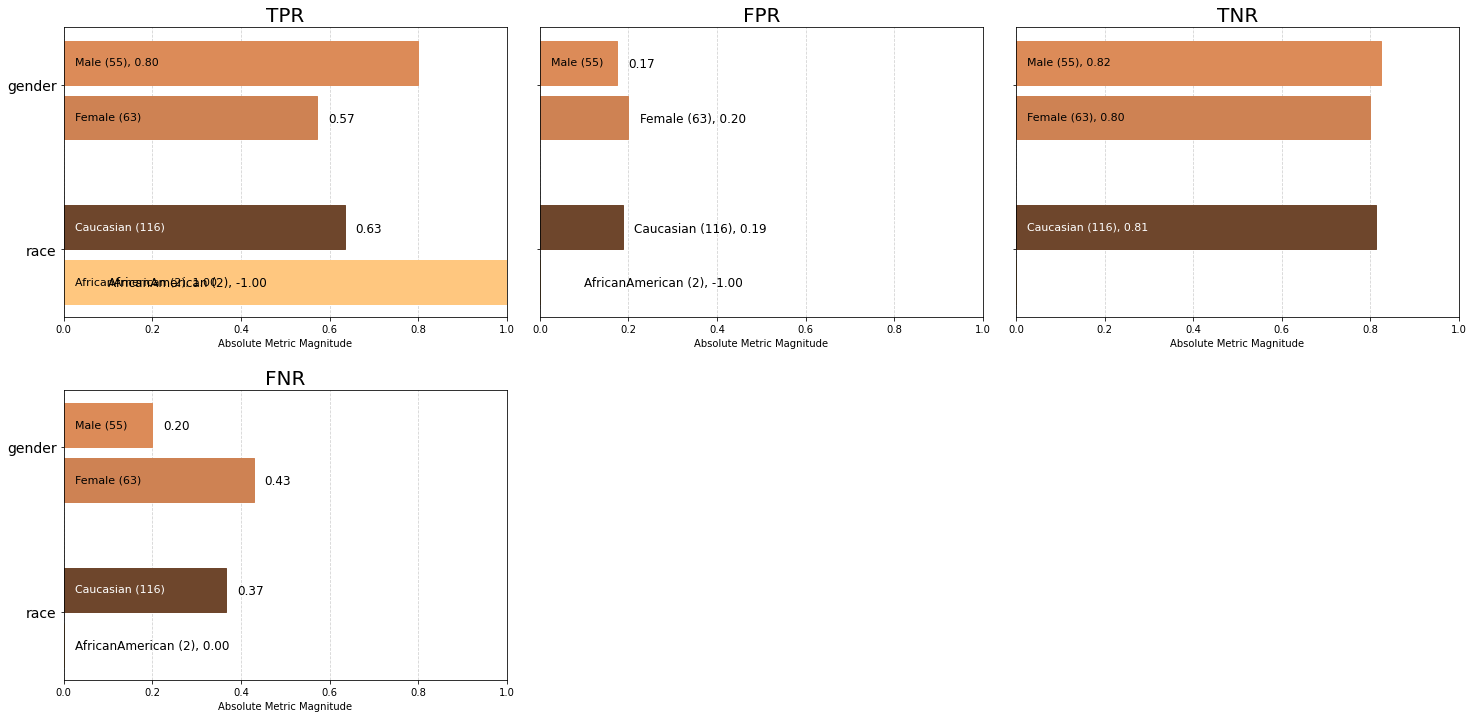

In [182]:
# Plot two metrics

# Is there significant bias in your model for either race or gender?

absolute_metrics = g.list_absolute_metrics(clean_xtab)
clean_xtab[[col for col in clean_xtab.columns if col not in absolute_metrics]]

clean_xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

p = aqp.plot_group_metric_all(clean_xtab, metrics=['tpr', 'fpr', 'tnr', 'fnr'])

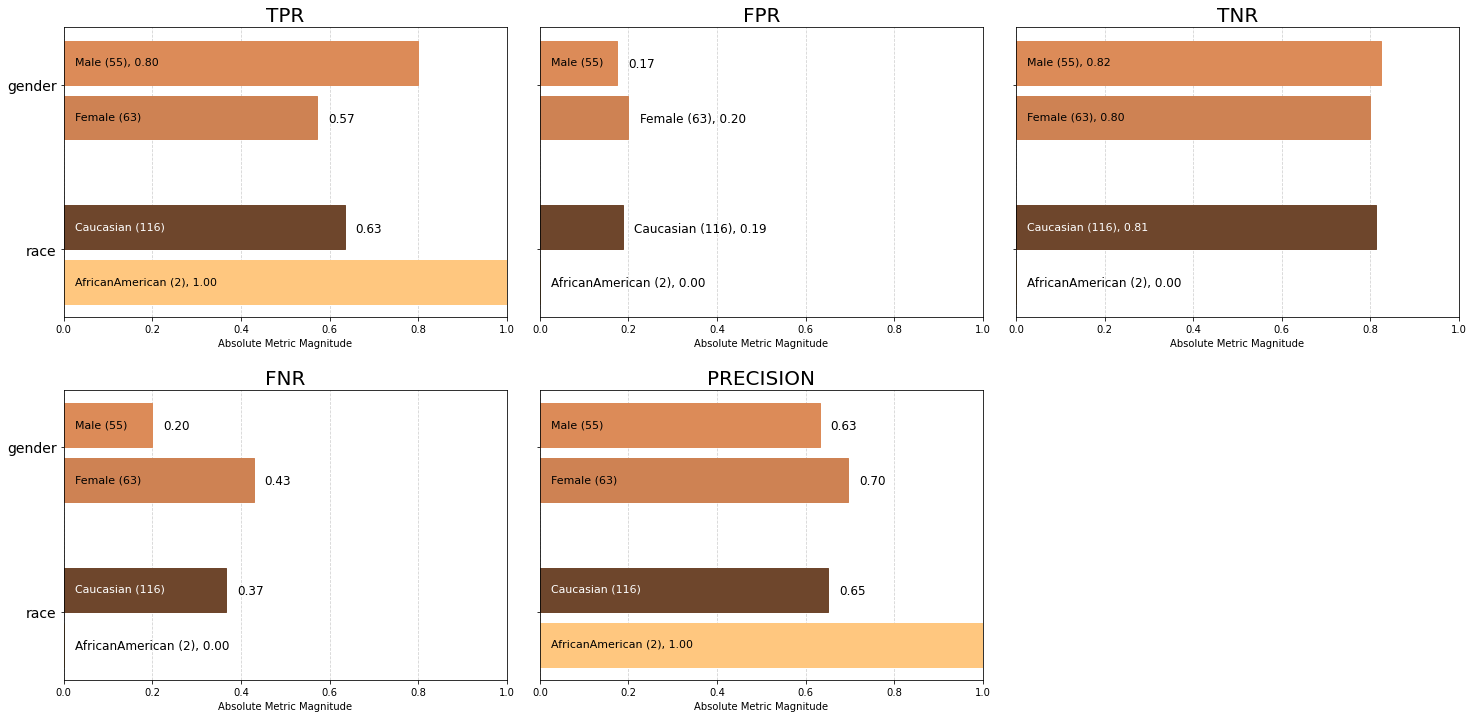

In [186]:
absolute_metrics = g.list_absolute_metrics(xtab)
xtab[[col for col in xtab.columns if col not in absolute_metrics]]

xtab[['attribute_name', 'attribute_value'] + absolute_metrics].round(2)

p = aqp.plot_group_metric_all(xtab, metrics=['tpr', 'fpr', 'tnr', 'fnr','precision'])

In [ ]:
# On the test data, the model is biased with the performance of AfricanAmerican based on samples as it have 
  # TPR equals to 1 and FPR equals to 0 with precision equals 1
  # FPR euqlas to 0

# This is also because as we have less test cases for AfricanAmerican .

## Fairness Analysis Example - Relative to a Reference Group 

**Question 13**: Earlier we defined our reference group and then calculated disparity metrics relative to this grouping. Please provide a visualization of the fairness evaluation for this reference group and analyze whether there is disparity.

In [187]:
# Reference group fairness plot

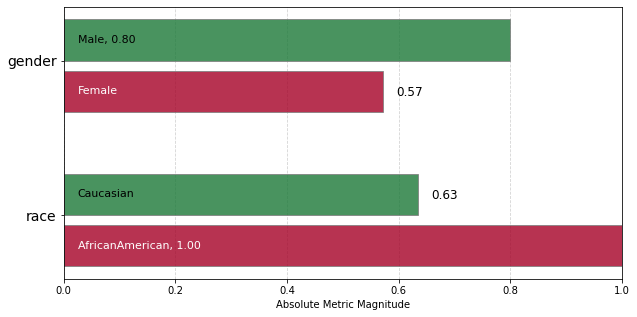

In [192]:
tpr_disparity_fairness = aqp.plot_fairness_group(fdf, group_metric='tpr')

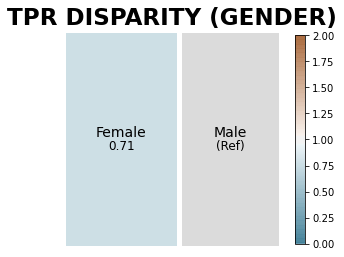

In [197]:
 fpr_disparity = aqp.plot_disparity(bdf, group_metric='tpr_disparity', 
                                       attribute_name='gender')

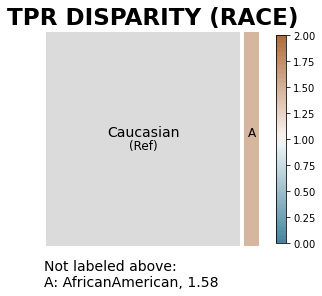

In [198]:
 fpr_disparity = aqp.plot_disparity(bdf, group_metric='tpr_disparity', 
                                       attribute_name='race')

In [ ]:
#TPR for AfricanAmerican is 1.58 times than Causasian
#TPR for Female is 0.71 times than of Male.